In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tqdm.notebook import tqdm
from statistics import mean
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data = pd.concat([data_train, data_test], ignore_index = True)

## 1. Exploratory Data Analysis



### 1.1 Overview
- `PassengerId` is the unique id of the row and it doesn't have any effect on target
- `Survived` is the target variable we are trying to predict (0 or 1):
    - **1 = Survived**
    - **0 = Not Survived**
- `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 or 3):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
- `Name`, `Sex` and `Age` are self-explanatory
- `SibSp` is the total number of the passengers' siblings and spouse
- `Parch` is the total number of the passengers' parents and children
- `Ticket` is the ticket number of the passenger
- `Fare` is the passenger fare
- `Cabin` is the cabin number of the passenger, format: Capital letter followed by numbers ---- e.g. A36
- `Embarked` is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [3]:
print(data_train.info())
data_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.2 Missing Values

#### 1.2.1 Missing counts in training set

- `Age`: 177
- `Cabin`: 687
- `Embarked`: 2

<AxesSubplot:>

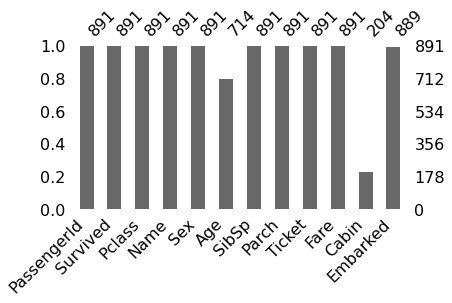

In [4]:
msno.bar(data_train, figsize=(6,3))

#### 1.2.2 Missing counts in test set

- `Age`: 86
- `Cabin`: 327
- `Fare`: 1

<AxesSubplot:>

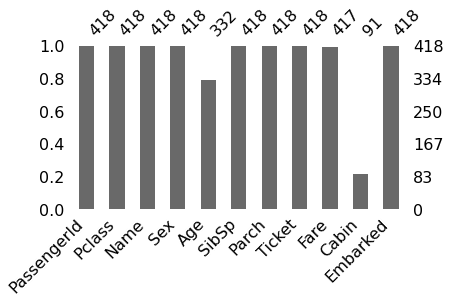

In [5]:
msno.bar(data_test, figsize=(6,3))

### 1.3 Single variable perspecive

#### 1.3.1 Training set

In [6]:
print(data_train[['Survived', 'Pclass']].value_counts().sort_index(),
      data_train[['Survived', 'Sex']].value_counts().sort_index(),
      data_train[['Survived', 'SibSp']].value_counts().sort_index(),
      data_train[['Survived', 'Parch']].value_counts().sort_index(),
      data_train[['Survived', 'Embarked']].value_counts(dropna=False).sort_index())

Survived  Pclass
0         1          80
          2          97
          3         372
1         1         136
          2          87
          3         119
dtype: int64 Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
dtype: int64 Survived  SibSp
0         0        398
          1         97
          2         15
          3         12
          4         15
          5          5
          8          7
1         0        210
          1        112
          2         13
          3          4
          4          3
dtype: int64 Survived  Parch
0         0        445
          1         53
          2         40
          3          2
          4          4
          5          4
          6          1
1         0        233
          1         65
          2         40
          3          3
          5          1
dtype: int64 Survived  Embarked
0         C            75
          Q            47
          S        

In [7]:
# replace Cabin number as the first capital letter
data_train_temp = data_train.copy()
data_test_temp = data_test.copy()

for i in range(65,90):
    data_train_temp.loc[data_train_temp['Cabin'].notnull() 
                            & data_train_temp['Cabin'].str.startswith(chr(i)), 'Cabin'] = chr(i)
for i in range(65,90):
    data_test_temp.loc[data_test_temp['Cabin'].notnull() 
                            & data_test_temp['Cabin'].str.startswith(chr(i)), 'Cabin'] = chr(i)    

In [8]:
# replace name with only prefix 
prefix = ['Mr. ', 'Mrs. |Ms. ', 'Miss. ', 'Don. ', 'Dona. ', 'Mlle. ', 'Mme. ', 'Dr. ', 'Col. ', 'Capt. ',
          'Sir. ', 'Master. ', 'Major. ', 'Rev. ', 'Jonkheer. ', 'Lady. ', 'the Countess. ']

for i in prefix:
    data_train_temp.loc[data_train_temp['Name'].str.contains(i), 'Name'] = i
for i in prefix:
    data_test_temp.loc[data_test_temp['Name'].str.contains(i), 'Name'] = i

In [9]:
print(data_train_temp[['Cabin', 'Survived']].value_counts(dropna=False).sort_index(),
     data_train_temp[['Name', 'Survived']].value_counts().sort_index())

Cabin  Survived
A      0             8
       1             7
B      0            12
       1            35
C      0            24
       1            35
D      0             8
       1            25
E      0             8
       1            24
F      0             5
       1             8
G      0             2
       1             2
T      0             1
NaN    0           481
       1           206
dtype: int64 Name            Survived
Capt.           0             1
Col.            0             1
                1             1
Don.            0             1
Dr.             0             4
                1             3
Jonkheer.       0             1
Major.          0             1
                1             1
Master.         0            17
                1            23
Miss.           0            54
                1           126
Mlle.           1             1
Mme.            1             1
Mr.             0           437
                1            84
Mrs. |Ms.  

### *Inference from above* :<br><br>

- The total number of training example is *891*

- The overall probability of surviving is *0.38*

For each **categorical variable**, the **proportion** and corresponding **survival probability** is:
- For variable `Pclass`:
    - **Upper Class : 24.24% ---- 0.63**
    - **Middle Class : 20.65% ---- 0.47**
    - **Lower Class : 55.11% ---- 0.24**
- For variable `Sex`:
    - **Female : 35.24% ---- 0.74**
    - **Male : 64.76% ---- 0.19**
- For variable `SibSp`:
    - **0 : 68.24% ---- 0.35**
    - **1 : 23.46% ---- 0.54**
    - **2 : 3.14% ---- 0.46**
    - **3 : 1.80% ---- 0.25**
    - **4 : 2.02% ---- 0.17**
    - **5 : 0.56% ---- 0.00**
    - **8 : 0.79% ---- 0.00**
- For variable `Parch`:
    - **0 : 76.09% ---- 0.34**
    - **1 : 13.24% ---- 0.55**
    - **2 : 8.98% ---- 0.50**
    - **3 : 0.56% ---- 0.60**
    - **4 : 0.45% ---- 0.00**
    - **5 : 0.56% ---- 0.20**
    - **6 : 0.11% ---- 0.00**
- For variable `Embarked`:
    - **Cherbourg : 18.86% ---- 0.55**
    - **Queenstown : 8.64% ---- 0.39**
    - **Southampton : 72.28% ---- 0.34**
- For variable `Cabin`:
    - **A : 1.68% ---- 0.47**
    - **B : 5.27% ---- 0.74**
    - **C : 6.62% ---- 0.59**
    - **D : 3.70% ---- 0.76**
    - **E : 3.59% ---- 0.75**
    - **F : 1.46% ---- 0.62**
    - **G : 0.45% ---- 0.50**
    - **T : 0.11% ---- 0.00**
- For variable `Name`:
    - **Capt. : 0.11% ---- 0.00**
    - **Col. : 0.22% ---- 0.50**
    - **Don. : 0.11% ---- 0.00**   
    - **Dr. : 0.79% ---- 0.43**
    - **Jonkheer. : 0.11% ---- 0.00** 
    - **Major. : 0.22% ---- 0.50**
    - **Master. : 4.49% ---- 0.58**
    - **Miss. : 20.20% ---- 0.70**
    - **Mlle. : 0.11% ---- 1.00**
    - **Mme. : 0.11% ---- 1.00**
    - **Mr. : 58.47% ---- 0.16**
    - **Mrs.|Ms. : 14.14% ---- 0.79**
    - **Rev. : 0.67% ---- 0.00**
    - **Sir. : 0.11% ---- 1.00**
    - **the Countess. : 0.11% ---- 1.00**

For each **bin** of **Continuous Variable**, the **proportion** and corresponding **survival probability** is:

- For variable `Age`:
    - **0-10 : 2.92% ---- 0.00**
    - **11-19 :

#### 1.3.2 Test set

In [10]:
print(data_test[['Pclass']].value_counts().sort_index(),
      data_test[['Sex']].value_counts().sort_index(),
      data_test[['SibSp']].value_counts().sort_index(),
      data_test[['Parch']].value_counts().sort_index(),
      data_test[['Embarked']].value_counts().sort_index(),
      data_test_temp[['Cabin']].value_counts(dropna=False).sort_index(),
      data_test_temp[['Name']].value_counts().sort_index())

Pclass
1         107
2          93
3         218
dtype: int64 Sex   
female    152
male      266
dtype: int64 SibSp
0        283
1        110
2         14
3          4
4          4
5          1
8          2
dtype: int64 Parch
0        324
1         52
2         33
3          3
4          2
5          1
6          1
9          2
dtype: int64 Embarked
C           102
Q            46
S           270
dtype: int64 Cabin
A          7
B         18
C         35
D         13
E          9
F          8
G          1
NaN      327
dtype: int64 Name      
Col.            2
Dona.           1
Dr.             1
Master.        21
Miss.          78
Mr.           240
Mrs. |Ms.      73
Rev.            2
dtype: int64


### *Inference from above* :<br><br>

- The total number of test sample is 418

For each **categorical variable**, the **proportion** is:
- For variable `Pclass`:
    - **Upper Class : 25.60%**
    - **Middle Class : 22.25%**
    - **Lower Class : 52.15**
- For variable `Sex`:
    - **Female : 36.36%**
    - **Male : 63.64%**
- For variable `SibSp`:
    - **0 : 67.70%**
    - **1 : 26.32%**
    - **2 : 3.35%**
    - **3 : 0.96%**
    - **4 : 0.96%**
    - **5 : 0.24%**
    - **8 : 0.48%**
- For variable `Parch`:
    - **0 : 77.51%**
    - **1 : 12.44%**
    - **2 : 7.89%**
    - **3 : 0.72%**
    - **4 : 0.48%**
    - **5 : 0.24%**
    - **6 : 0.24%**
    - **9 : 0.48%**
- For variable `Embarked`:
    - **Cherbourg : 24.40%**
    - **Queenstown : 11.00%**
    - **Southampton : 64.59%**
- For variable `Cabin`:
    - **A : 1.67%**
    - **B : 4.31%**
    - **C : 8.37%**
    - **D : 3.11%**
    - **E : 2.15%**
    - **F : 1.91%**
    - **G : 0.24%** 
- For variable `Name`:
    - **Col. : 0.48%**
    - **Dona. : 0.24%**   
    - **Dr. : 0.24%**
    - **Master. : 5.02%**
    - **Miss. : 18.66%**
    - **Mr. : 57.42%**
    - **Mrs.|Ms. : 17.46%**
    - **Rev. : 0.48%**

### 1.4 Situation inference from `Ticket`

By far the most important variable, which gives tons of information to what happened on Titanic.

#### 1.4.1 Information of all ticket number

The same ticket number must indicate the same `Pclass`, `Cabin`, `Embarked` (only with very few exceptions) and `Fare` (only one exception, but is very closed), from data.

In [11]:
exclude = ['CA. 2343', '1601', 'CA 2144', '347077', 'S.O.C. 14879']

In [12]:
data.loc[~data['Ticket'].isin(exclude), 'Ticket'].value_counts()

3101295     7
PC 17608    7
347082      7
19950       6
347088      6
           ..
113792      1
36209       1
323592      1
315089      1
359309      1
Name: Ticket, Length: 924, dtype: int64

In [13]:
data.loc[data['Ticket'] == 'PC 17760']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
269,270,1.0,1,"Bissette, Miss. Amelia",female,35.0,0,0,PC 17760,135.6333,C99,S
325,326,1.0,1,"Young, Miss. Marie Grice",female,36.0,0,0,PC 17760,135.6333,C32,C
373,374,0.0,1,"Ringhini, Mr. Sante",male,22.0,0,0,PC 17760,135.6333,NaN,C
1205,1206,NaN,1,"White, Mrs. John Stuart (Ella Holmes)",female,55.0,0,0,PC 17760,135.6333,C32,C


? passengers were not alone

11 * 

CA. 2343: except 4 from test set, none of them survived. 9 has SibSp 8, Parch 2 and 2 has SibSp 1, Parch 9. They are a family of 2 parents and 9 children. 3rd class, 

8 * 

1601: except 1 from test set, 5 of them survived. All of them has no SibSp or Parch. They are friends or strangers.
CA 2144: except 2 from test set, none of them survived. 6 has SibSp 5, Parch 2 and 2 has SibSp 1, Parch 6. They are a family of 2 parents and 6 children.

7 *

347077: except 3 from test set, 3 of them survived. 5 has SibSp 4, Parch 2 and 2 has SibSp 1, Parch 5. They are a family of 2 parents and 5 children.
3101295: except 1 from test set, 
S.O.C. 14879: except 2 from test set, none of them survived. 3 has SibSp 2, rest all 0. 3 siblings and 4 friends or strangers.


347082: 0 out of 7 survived, all NaN Cabin, all same Fare, Embarked S, 3rd class


347088: 0 out of 6 survived, all NaN Cabin, all same Fare, Embarked S, 3rd class
3101295: 0 out of 6 survived, all NaN Cabin, all same Fare, Embarked S, 3rd class
CA 2144: 0 out of 6 survived, all NaN Cabin, all same Fare, Embarked S, 3rd class


382652: 0 out of 5 survived, all NaN Cabin, all same Fare, Embarked Q, 3rd class


2666: 4 out of 4 survived, all NaN Cabin, all same Fare, Embarked C, 3rd class
4133: 0 out of 4 survived, all NaN Cabin, all same Fare, Embarked S, 3rd class
17421: 3 out of 4 survived, except 1 NaN Cabin, all same Cabin, Fare, Embarked C, 1st class
19950: 2 out of 4 survived, all same Cabin, Fare, Embarked S, 1st class
113760: 4 out of 4 survived, all same Cabin, Fare, Embarked S, 1st class
113781: 2 out of 4 survived, except 1 NaN Cabin, all same Cabin, Fare, Embarked S, 1st class
349909: 0 out of 4 survived, all NaN Cabin, all same Fare, Embarked S, 3rd class
LINE: 1 out of 4 survived, all NaN Cabin, all same Fare, Embarked C, 3rd class
PC 17757: 3 out of 4 survived, except 2 NaN Cabin, all same Cabin, Fare, Embarked C, 1st class
W./C. 6608: 0 out of 4 survived, all NaN Cabin, all same Fare, Embarked S, 3rd class


13502: 3 out of 3 survived, all same Cabin, Fare, Embarked S, 1st class
24160: 3 out of 3 survived, all same Cabin, Fare, Embarked S, 1st class
29106: 3 out of 3 survived, all NaN Cabin, all same Fare, Embarked S, 2nd class
35273: 2 out of 3 survived, all same Cabin, Fare, Embarked C, 1st class
110152: 3 out of 3 survived, all same Cabin, Fare, Embarked S, 1st class
110413: 2 out of 3 survived, all same Cabin, Fare, Embarked S, 1st class
230080: 2 out of 3 survived, all same Cabin, Fare, Embarked S, 2nd class
239853: 0 out of 3 survived, all NaN Cabin, all same Fare, Embarked S, 2nd class
248727: 2 out of 3 survived, all NaN Cabin, all same Fare, Embarked S, 2nd class
345773: 0 out of 3 survived, all NaN Cabin, all same Fare, Embarked S, 3rd class
347742: 3 out of 3 survived, all NaN Cabin, all same Fare, Embarked S, 3rd class
363291: 2 out of 3 survived, all NaN Cabin, all same Fare, Embarked S, 3rd class
371110: 1 out of 3 survived, all NaN Cabin, all same Fare, Embarked Q, 3rd class
C.A. 31921: 2 out of 3 survived, all NaN Cabin, all same Fare, Embarked S, 2nd class
C.A. 34651: 2 out of 3 survived, all NaN Cabin, all same Fare, Embarked S, 2nd class
F.C.C. 13529: 2 out of 3 survived, all NaN Cabin, all same Fare, Embarked S, 2nd class
PC 17572: 3 out of 3 survived, all same Cabin, Fare, Embarked C, 1st class
PC 17582: 2 out of 3 survived, all same Cabin, Fare, Embarked S, 1st class
PC 17755: 3 out of 3 survived, except 1 NaN Cabin, all same Cabin, Fare, Embarked C, 1st class
PC 17760: 2 out of 3 survived, except 1 NaN Cabin, 1 Embarked S, all same Cabin, Fare, Embarked C, 1st class
SC/Paris 2123: 2 out of 3 survived, all NaN Cabin, all same Fare, Embarked C, 2nd class


2627: 0 out of 2 survived, NaN Cabin, same Fare, Embarked C, 3rd class
2651: 2 out of 2 survived, NaN Cabin, same Fare, Embarked C, 3rd class
2653: 2 out of 2 survived, NaN Cabin, same Fare, Embarked C, 3rd class
2659: 1 out of 2 survived, NaN Cabin, same Fare, Embarked C, 3rd class
2661: 2 out of 2 survived, NaN Cabin, same Fare, Embarked C, 3rd class
2665: 0 out of 2 survived, NaN Cabin, same Fare, Embarked C, 3rd class
2668: 2 out of 2 survived, 1 NaN Cabin, same Fare, Embarked C, 3rd class
2678: 0 out of 2 survived, NaN Cabin, same Fare, Embarked C, 3rd class
2691: 0 out of 2 survived, NaN Cabin, same Fare, Embarked C, 3rd class
2699: 1 out of 2 survived, NaN Cabin, same Fare, Embarked C, 3rd class
2908: 2 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
7534: 0 out of 2 survived, NaN Cabin, almost same Fare (0.6 difference), same Embarked S, 3rd class
11668:  0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
11751: 2 out of 2 survived, same Cabin, Fare, Embarked S, 1st class
11767: 2 out of 2 survived, same Cabin, Fare, Embarked C, 1st class
11967: 2 out of 2 survived, same Cabin, Fare, Embarked C, 1st class
12749: 2 out of 2 survived, same Cabin, Fare, Embarked S, 1st class
13507: 1 out of 2 survived, same Cabin, Fare, Embarked S, 1st class
16966: 2 out of 2 survived, same Cabin, Fare, Embarked C, 1st class
17453: 2 out of 2 survived, 1 NaN age, same Cabin, Fare, Embarked C, 1st class
17474: 2 out of 2 survived, same Cabin, Fare, Embarked S, 1st class
19877: 1 out of 2 survived, 1 NaN Cabin, same Fare, Embarked S, 1st class
19928: 1 out of 2 survived, same Cabin, Fare, Embarked Q, 1st class
19943: 2 out of 2 survived, same Cabin, Fare, Embarked S, 1st class
19996: 2 out of 2 survived, 1 NaN age, same Cabin, Fare, Embarked S, 1st class
26360: 2 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
28403: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
29750: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
31027: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
35281: 0 out of 2 survived, same Cabin, Fare, Embarked S, 1st class
36928: 2 out of 2 survived, 1 NaN Cabin, same Fare, Embarked S, 1st class
36947: 2 out of 2 survived, same Cabin, Fare, Embarked C, 1st class
36973: 2 out of 2 survived, NaN Embarked, same Cabin, Fare, 1st class
54636: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
110465: 0 out of 2 survived, different Cabin, same Fare, Embarked S, 1st class
111361: 2 out of 2 survived, same Cabin, Fare, Embarked C, 1st class
113505: 2 out of 2 survived, same Cabin, Fare, Embarked S, 1st class
113572: 2 out of 2 survived, NaN Embarked, same Cabin, Fare, 1st class
113776: 1 out of 2 survived, same Cabin, Fare, Embarked S, 1st class
113789: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 1st class
113798: 1 out of 2 survived, NaN Cabin, different Embarked, same Fare, 1st class
113803: 1 out of 2 survived, same Cabin, Fare, Embarked S, 1st class
113806: 2 out of 2 survived, same Cabin, Fare, Embarked S, 1st class
220845: 2 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
230136: 2 out of 2 survived, same Cabin, Fare, Embarked S, 2nd class
230433: 2 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
231919:  2 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
237736: 1 out of 2 survived, NaN Cabin, same Fare, Embarked C, 2nd class
239865: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
243847: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
244252: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
244367: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
248738: 2 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
250644: 2 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
250647: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
250649: 2 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
250655: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
345764: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
347054: 0 out of 2 survived, same Cabin, Fare, Embarked S, 3rd class
347080: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
349237: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
358585: 0 out of 2 survived, 1 NaN age, NaN Cabin, same Fare, Embarked S, 3rd class
364516: 2 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
364849: 0 out of 2 survived, NaN Cabin, same Fare, Embarked Q, 3rd class
367226: 2 out of 2 survived, NaN Cabin, age, same Fare, Embarked Q, 3rd class
367230: 2 out of 2 survived, NaN Cabin, age, same Fare, Embarked Q, 3rd class
370129: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
370365: 1 out of 2 survived, NaN Cabin, same Fare, Embarked Q, 3rd class
376564: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
392096: 2 out of 2 survived, same Cabin, Fare, Embarked S, 3rd class
3101278: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
A/4 48871: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
A/5. 3336: 0 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
C.A. 2315: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
C.A. 2673: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
C.A. 33112: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 2nd class
C.A. 37671: 2 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
PC 17477: 2 out of 2 survived, same Cabin, Fare, Embarked C, 1st class
PC 17485: 2 out of 2 survived, different Cabin, same Fare, Embarked C, 1st class
PC 17558: 1 out of 2 survived, same Cabin, Fare, Embarked C, 1st class
PC 17569: 2 out of 2 survived, 1 NaN age, same Cabin, Fare, Embarked C, 1st class
PC 17593: 0 out of 2 survived, Same Cabin, Fare, Embarked C, 1st class
PC 17604: 1 out of 2 survived, 1 NaN age, NaN Cabin, same Fare, Embarked C, 1st class
PC 17608: 2 out of 2 survived, same Cabin, Fare, Embarked C, 1st class
PC 17611: 2 out of 2 survived, 1 age NaN, NaN Cabin, same Fare, Embarked S, 1st class
PC 17758: 1 out of 2 survived, same Cabin, Fare, Embarked C, 1st class
PC 17761: 1 out of 2 survived, 1 NaN Cabin, same Fare, Embarked C, 1st class
PP 9549: 2 out of 2 survived, same Cabin, Fare, Embarked S, 3rd class
P/PP 3381: 1 out of 2 survived, NaN Cabin, same Fare, Embarked C, 2nd class
S.C./PARIS 2079: 1 out of 2 survived, NaN Cabin, same Fare, Embarked C, 2nd class
S.O./P.P. 3: 0 out of 2 survived, 1 NaN Cabin, same Fare, Embarked S, 2nd class
STON/O2. 3101279: 1 out of 2 survived, NaN Cabin, same Fare, Embarked S, 3rd class
W./C. 6607: 0 out of 2 survived, NaN age, Cabin, same Fare, Embarked S, 3rd class
WE/P 5735: 1 out of 2 survived, same Cabin, Fare, Embarked S, 1st class

#### 1.4.2 Discovery

From early EDA, we find that female has a survival rate of 0.74 while 0.19 for male. Also, 1st-class has 0.63 while 3rd-class has 0.24. At the first glance, passengers whose gender is male or whose ticket is 3rd-class are highly unlikely to survive compared to passengers whose gender is female or whose ticket is 1st-class ticket.

Every passenger has a ticket number. While some passengers share the same ticket number, other ticket numbers are unique. The range of number of occurence of a ticket number is [0,7]. For occurence equals to:

- 7: There are 3 distinct ticket numbers, and all of them are 3rd-class ticket. For ticket number
    - '1601': All of them are male, have no SibSp or Parch, which means they can be friends or strangers, but 5 of them survived.
    - '347082': Although 5 of them are female, none of them survived. 5 of them has SibSp 4, Parch 2 and 2 of them has SibSp 1, Parch 5.
    - 'CA. 2343': Only 3 of them are female, but all of them has SibSp 8 and Parch 2. None of them survived.
    
- 6: There are 3 distinct ticket numbers, and all of them are 3rd-class ticket. For ticket number
    - '347088': Half of them are female, and none of them survived. 4 of them has SibSp 3, Parch 2 and 2 of them has SibSp 1, Parch 4.
    - '3101295': Although only 1 female, none of them survived. The only female has SibSp 0, Parch 5 and the rest has SibSp 4, Parch 1
    - 'CA 2144': Only 2 of them are female, 5 of them has SibSp 5, Parch 2 and the other female has Parch SibSp 1, Parch 6. None of them survived.
    
- 5: There are 2 distinct ticket numbers, one is 3rd-class and the other is 2nd-class. For ticket number
    - '382652': 3rd-class ticket. Only 1 of them is female, and she has SibSp 0, Parch 5. The rest has SibSp 4, Parch 1. None of them survived.
    - 'S.O.C. 14879': 2nd-class ticket. All of them are male, except 2 has SibSp 2, Parch 0, the rest has no SibSp or Parch. Although they are similar to '1601' passengers, none of them survived.
    
For ticket occurence greater than 4, except ticket '1601', none of them survived.

- 4: There are 11 distinct ticket numbers, 5 are 1st-class and 6 are 3rd-class. For ticket number
    - 1st class:
        - '17421': Half of them are female. 2 has SibSp 1, Parch 1. 1 has SibSp 0, Parch 1 and 1 has no SibSp or Parch. Only the male with 1 SibSp and Parch did not survive.
        - '19950': Half of them are female. 3 has SibSp 3, Parch 2, the other has SibSp 1, Parch 4. Only the female survived.
        - '113760': Half of them are female. All of them has SibSp 1, Parch 2. All of them survived.
        - '113781': 3 of them are female. 3 has SibSp 1, Parch 2 and the other has no SibSp or Parch. Only one male with age 0.92 and the female with no SibSp or Parch survived.
        - 'PC 17757': Only one of them is male and did not survived. Except one female has SibSp 1, Parch 0, all of them has no SibSp or Parch.
    - 3rd class:
        - '2666': All of them are female, 1 has SibSp 0, Parch 3 and the rest has SibSp 2, Parch 1. All of them survived.
        - '4133': Only 1 female, all of them has SibSp 3, Parch 1. None of them survived.
        - '347077': Half of them are female. 3 of them has SibSp 4, Parch 2 and the other female has SibSp 1, Parch 5. Except 1 male, all of them survived.
        - '349909': Only 1 of them are male. 3 of them has SibSp 3, Parch 1 and the other female has SibSp 0, Parch 4. None of them survived.
        - 'LINE': All of them are male and has no SibSp or Parch. Only one of them survived.
        - 'W./C. 6608': 3 of them are female. 2 female has SibSp 2, Parch 2 and the rest has SibSp 1, Parch 3. None of them survived.

In [11]:
ticket_count = pd.DataFrame(data_train['Ticket'].value_counts())
ticket_count = ticket_count.loc[ticket_count['Ticket'] > 1]
ticket_group = data_train.loc[data_train['Ticket'].isin(ticket_count.index)]

In [12]:
data_train.loc[data_train['Ticket'] == 'W./C. 6608']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
86,87,0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.375,NaN,S
147,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.375,NaN,S
436,437,0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2,W./C. 6608,34.375,NaN,S
736,737,0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.375,NaN,S


## 2. Feature Engineering

### 2.1 Discard irrelevant columns

We drop the variable `PassengerId` since it contains no information.

In [14]:
data.drop('PassengerId', axis = 1, inplace = True)
test_index = data_test['PassengerId']

### 2.2 Fill missing values

#### 2.2.1 `Age`

We can infer from other variables to improve accuracy of filled values.<br><br>
e.g.:
- `SibSp`, `Parch` and `Ticket`: <br>

If one has more than one SibSp or Parch, we can not only secure the corresponding age distribution, but also infer the status (parent of kid) of the passenger in the family so that the possible age can be further narrowed down; 

Else if one has no family on the Titanic, we can also know that this passenger has a relative high age, at least not a minor.
- `Master.`: <br>

It is a prefix of name that indicates the young male group (but not all of this group has this prefix). Hence, a missing age with this prefix must be filled from the age distribution of this group

From below, we can see the distinct number of SibSp and Parch of passengers with missing age. The passengers with high SibSp or Parch can be inferred.

In [13]:
data.loc[data['Age'].isnull(), ['SibSp', 'Parch']].value_counts().sort_index()

SibSp  Parch
0      0        200
       1          1
       2          4
       4          1
1      0         28
       1          5
       2          4
       9          2
2      0          6
3      1          4
8      2          8
dtype: int64

#### - Let's first see the group with 8 `SibSp` and 0 `Parch`:

In [16]:
data.loc[(data['Age'].isnull()) & (data['SibSp'] == 8)]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S
1079,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S


When we locate their `Ticket` number, we can tell that they are a family of 2 parents and 9 children.

In [26]:
data.loc[data['Ticket'] == 'CA. 2343']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S
1079,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S
1233,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.55,NaN,S
1251,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,NaN,S


#### - Next, when we check passengers with 3 `SibSp` and 1 `Parch` and locate their `Ticket`, we will find they are a family of 1 parent and 4 children:

In [27]:
data.loc[(data['Age'].isnull()) & (data['SibSp'] == 3)]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
176,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S
229,3,"Lefebre, Miss. Mathilde",female,NaN,3,1,4133,25.4667,NaN,S
409,3,"Lefebre, Miss. Ida",female,NaN,3,1,4133,25.4667,NaN,S
485,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S


In [32]:
data.loc[data['Ticket'] == '4133']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
176,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S
229,3,"Lefebre, Miss. Mathilde",female,NaN,3,1,4133,25.4667,NaN,S
409,3,"Lefebre, Miss. Ida",female,NaN,3,1,4133,25.4667,NaN,S
485,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
1023,3,"Lefebre, Mrs. Frank (Frances)",female,NaN,0,4,4133,25.4667,NaN,S


#### - Passengers with 2 `SibSp` and 0 `Parch`: (2 families, each with 3 siblings to each other)

In [31]:
data.loc[(data['Age'].isnull()) & (data['SibSp'] == 2)]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
48,3,"Samaan, Mr. Youssef",male,NaN,2,0,2662,21.6792,NaN,C
301,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q
330,3,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,NaN,Q
920,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C
1018,3,"McCoy, Miss. Alicia",female,NaN,2,0,367226,23.2500,NaN,Q
1188,3,"Samaan, Mr. Hanna",male,NaN,2,0,2662,21.6792,NaN,C


In [33]:
data.loc[data['Ticket'] == '2662']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
48,3,"Samaan, Mr. Youssef",male,NaN,2,0,2662,21.6792,NaN,C
920,3,"Samaan, Mr. Elias",male,NaN,2,0,2662,21.6792,NaN,C
1188,3,"Samaan, Mr. Hanna",male,NaN,2,0,2662,21.6792,NaN,C


In [34]:
data.loc[data['Ticket'] == '367226']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
301,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.25,NaN,Q
330,3,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.25,NaN,Q
1018,3,"McCoy, Miss. Alicia",female,NaN,2,0,367226,23.25,NaN,Q


#### - Passengers with 1 `SibSp` and 2 `Parch`: (a family of 2 parents and 2 children)

In [35]:
data.loc[(data['Age'].isnull()) & (data['SibSp'] == 1) & (data['Parch'] == 2)]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
783,3,"Johnston, Mr. Andrew G",male,NaN,1,2,W./C. 6607,23.45,NaN,S
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
924,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
1135,3,"Johnston, Master. William Arthur Willie""""",male,NaN,1,2,W./C. 6607,23.45,NaN,S


In [37]:
data.loc[data['Ticket'] == 'W./C. 6607']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
783,3,"Johnston, Mr. Andrew G",male,NaN,1,2,W./C. 6607,23.45,NaN,S
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
924,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
1135,3,"Johnston, Master. William Arthur Willie""""",male,NaN,1,2,W./C. 6607,23.45,NaN,S


#### - Passengers with 1 `SibSp` and 1 `Parch`: (3 families with 1 parent and 2 children for each)

In [39]:
data.loc[(data['Age'].isnull()) & (data['SibSp'] == 1) & (data['Parch'] == 1)]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
128,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
709,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
1235,3,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5000,NaN,S
1308,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [40]:
data.loc[data['Ticket'] == '2661']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
709,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
1116,3,"Moubarek, Mrs. George (Omine Amenia"" Alexander)""",female,NaN,0,2,2661,15.2458,NaN,C


In [41]:
data.loc[data['Ticket'] == '2668']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
128,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
533,3,"Peter, Mrs. Catherine (Catherine Rizk)",female,NaN,0,2,2668,22.3583,NaN,C
1308,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [42]:
data.loc[data['Ticket'] == 'A/5. 851']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
153,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5,NaN,S
1083,3,"van Billiard, Master. Walter John",male,11.5,1,1,A/5. 851,14.5,NaN,S
1235,3,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5,NaN,S


#### - Passengers with 1 `SibSp` and 0 `Parch`: (18 families of 11 couples, 6 pairs of siblings and 1 pair of sibling with 1child)

In [44]:
data.loc[(data['Age'].isnull()) & (data['SibSp'] == 1) & (data['Parch'] == 0)].sort_values('Ticket')

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
849,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C92,C
457,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D21,S
669,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",female,NaN,1,0,19996,52.0000,C126,S
1024,3,"Thomas, Mr. Charles P",male,NaN,1,0,2621,6.4375,NaN,C
1140,3,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",female,NaN,1,0,2660,14.4542,NaN,C
976,3,"Khalil, Mr. Betros",male,NaN,1,0,2660,14.4542,NaN,C
240,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C
578,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C
1257,3,"Caram, Mr. Joseph",male,NaN,1,0,2689,14.4583,NaN,C
1012,3,"Kiernan, Mr. John",male,NaN,1,0,367227,7.7500,NaN,Q


In [56]:
ticket_tmp = data.loc[(data['Age'].isnull()) & (data['SibSp'] == 1) & (data['Parch'] == 0), 'Ticket'].values
data.loc[data['Ticket'].isin(ticket_tmp)].sort_values('Ticket')

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
453,1,"Goldenberg, Mr. Samuel L",male,49.0,1,0,17453,89.1042,C92,C
849,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C92,C
457,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D21,S
1136,1,"Kenyon, Mr. Frederick R",male,41.0,1,0,17464,51.8625,D21,S
712,1,"Taylor, Mr. Elmer Zebley",male,48.0,1,0,19996,52.0000,C126,S
669,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",female,NaN,1,0,19996,52.0000,C126,S
1024,3,"Thomas, Mr. Charles P",male,NaN,1,0,2621,6.4375,NaN,C
976,3,"Khalil, Mr. Betros",male,NaN,1,0,2660,14.4542,NaN,C
1140,3,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",female,NaN,1,0,2660,14.4542,NaN,C
111,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C


#### - Passengers with 0 `SibSp` and 2 `Parch`: (except already mentioned, 1 family of 2 parents and 1 children)

In [65]:
data.loc[(data['Age'].isnull()) & (data['SibSp'] == 0) & (data['Parch'] == 2)].sort_values('Ticket')

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1116,3,"Moubarek, Mrs. George (Omine Amenia"" Alexander)""",female,NaN,0,2,2661,15.2458,NaN,C
533,3,"Peter, Mrs. Catherine (Catherine Rizk)",female,NaN,0,2,2668,22.3583,NaN,C
140,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C
593,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q


In [66]:
ticket_tmp = data.loc[(data['Age'].isnull()) & (data['SibSp'] == 0) & (data['Parch'] == 2), 'Ticket'].values
data.loc[data['Ticket'].isin(ticket_tmp)].sort_values('Ticket')

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
709,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
1116,3,"Moubarek, Mrs. George (Omine Amenia"" Alexander)""",female,NaN,0,2,2661,15.2458,NaN,C
128,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
533,3,"Peter, Mrs. Catherine (Catherine Rizk)",female,NaN,0,2,2668,22.3583,NaN,C
1308,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C
140,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C
852,3,"Boulos, Miss. Nourelain",female,9.0,1,1,2678,15.2458,NaN,C
971,3,"Boulos, Master. Akar",male,6.0,1,1,2678,15.2458,NaN,C
593,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q


In [69]:
data.loc[data['Name'].str.contains('Bourke,')]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
188,3,"Bourke, Mr. John",male,40.0,1,1,364849,15.50,NaN,Q
593,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.75,NaN,Q
657,3,"Bourke, Mrs. John (Catherine)",female,32.0,1,1,364849,15.50,NaN,Q


#### - Passengers with 0 `SibSp` and 1 `Parch`: (a family of 1 parent and 1 child)

In [70]:
data.loc[(data['Age'].isnull()) & (data['SibSp'] == 0) & (data['Parch'] == 1)].sort_values('Ticket')

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
166,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0,E33,S


In [71]:
data.loc[data['Ticket'] == '113505']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
166,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0,E33,S
356,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0,E33,S


#### - Passengers with no `SibSp` or `Parch`: 

In [72]:
data.loc[(data['Age'].isnull()) & (data['SibSp'] == 0) & (data['Parch'] == 0)]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...
1275,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1299,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
1301,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
1304,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S


In [84]:
ticket_tmp = data.loc[(data['Age'].isnull()) & (data['SibSp'] == 0) & (data['Parch'] == 0), 'Ticket'].values
data.loc[data['Ticket'].isin(ticket_tmp), 'Ticket'].value_counts()

1601        8
PC 17757    5
PC 17483    4
17421       4
371110      3
           ..
36209       1
323592      1
239854      1
330909      1
359309      1
Name: Ticket, Length: 193, dtype: int64

In [76]:
data.loc[data['Age'] == 5.0]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
58,2,"West, Miss. Constance Mirium",female,5.0,1,2,C.A. 34651,27.7500,NaN,S
233,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S
448,3,"Baclini, Miss. Marie Catherine",female,5.0,2,1,2666,19.2583,NaN,C
777,3,"Emanuel, Miss. Virginia Ethel",female,5.0,0,0,364516,12.4750,NaN,S
1270,3,"Asplund, Master. Carl Edgar",male,5.0,4,2,347077,31.3875,NaN,S


In [77]:
data.loc[data['Ticket'] == '364516']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
79,3,"Dowdell, Miss. Elizabeth",female,30.0,0,0,364516,12.475,NaN,S
777,3,"Emanuel, Miss. Virginia Ethel",female,5.0,0,0,364516,12.475,NaN,S


#### Fill missing age

In [15]:
data.loc[(data['Age'].isnull()
               ) & (data['Name'].str.contains('Master. ')), 'Age'
              ] = data.loc[data['Name'].str.contains('Master. '), 'Age'].mean()


data.loc[(data['Age'].isnull()
               ) & (data['Name'].str.contains('Dr. ')), 'Age'
              ] = data.loc[data['Name'].str.contains('Dr. '), 'Age'].mean()

data.loc[(data['Age'].isnull()
               ) & (data['Name'].str.contains('Mr. ')), 'Age'
              ] = data.loc[data['Name'].str.contains('Mr. '), 'Age'].mean()

data.loc[(data['Age'].isnull()
               ) & (data['Name'].str.contains('Mrs. |Ms. ')), 'Age'
              ] = data.loc[data['Name'].str.contains('Mrs. |Ms. '), 'Age'].mean()

data.loc[(data['Age'].isnull()
               ) & (data['Name'].str.contains('Miss. ')), 'Age'
              ] = data.loc[data['Name'].str.contains('Miss. '), 'Age'].mean()

#### 2.2.2 `Cabin`

Cabin feature is little bit tricky and it needs further exploration. The large portion of the Cabin feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the Cabin values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.

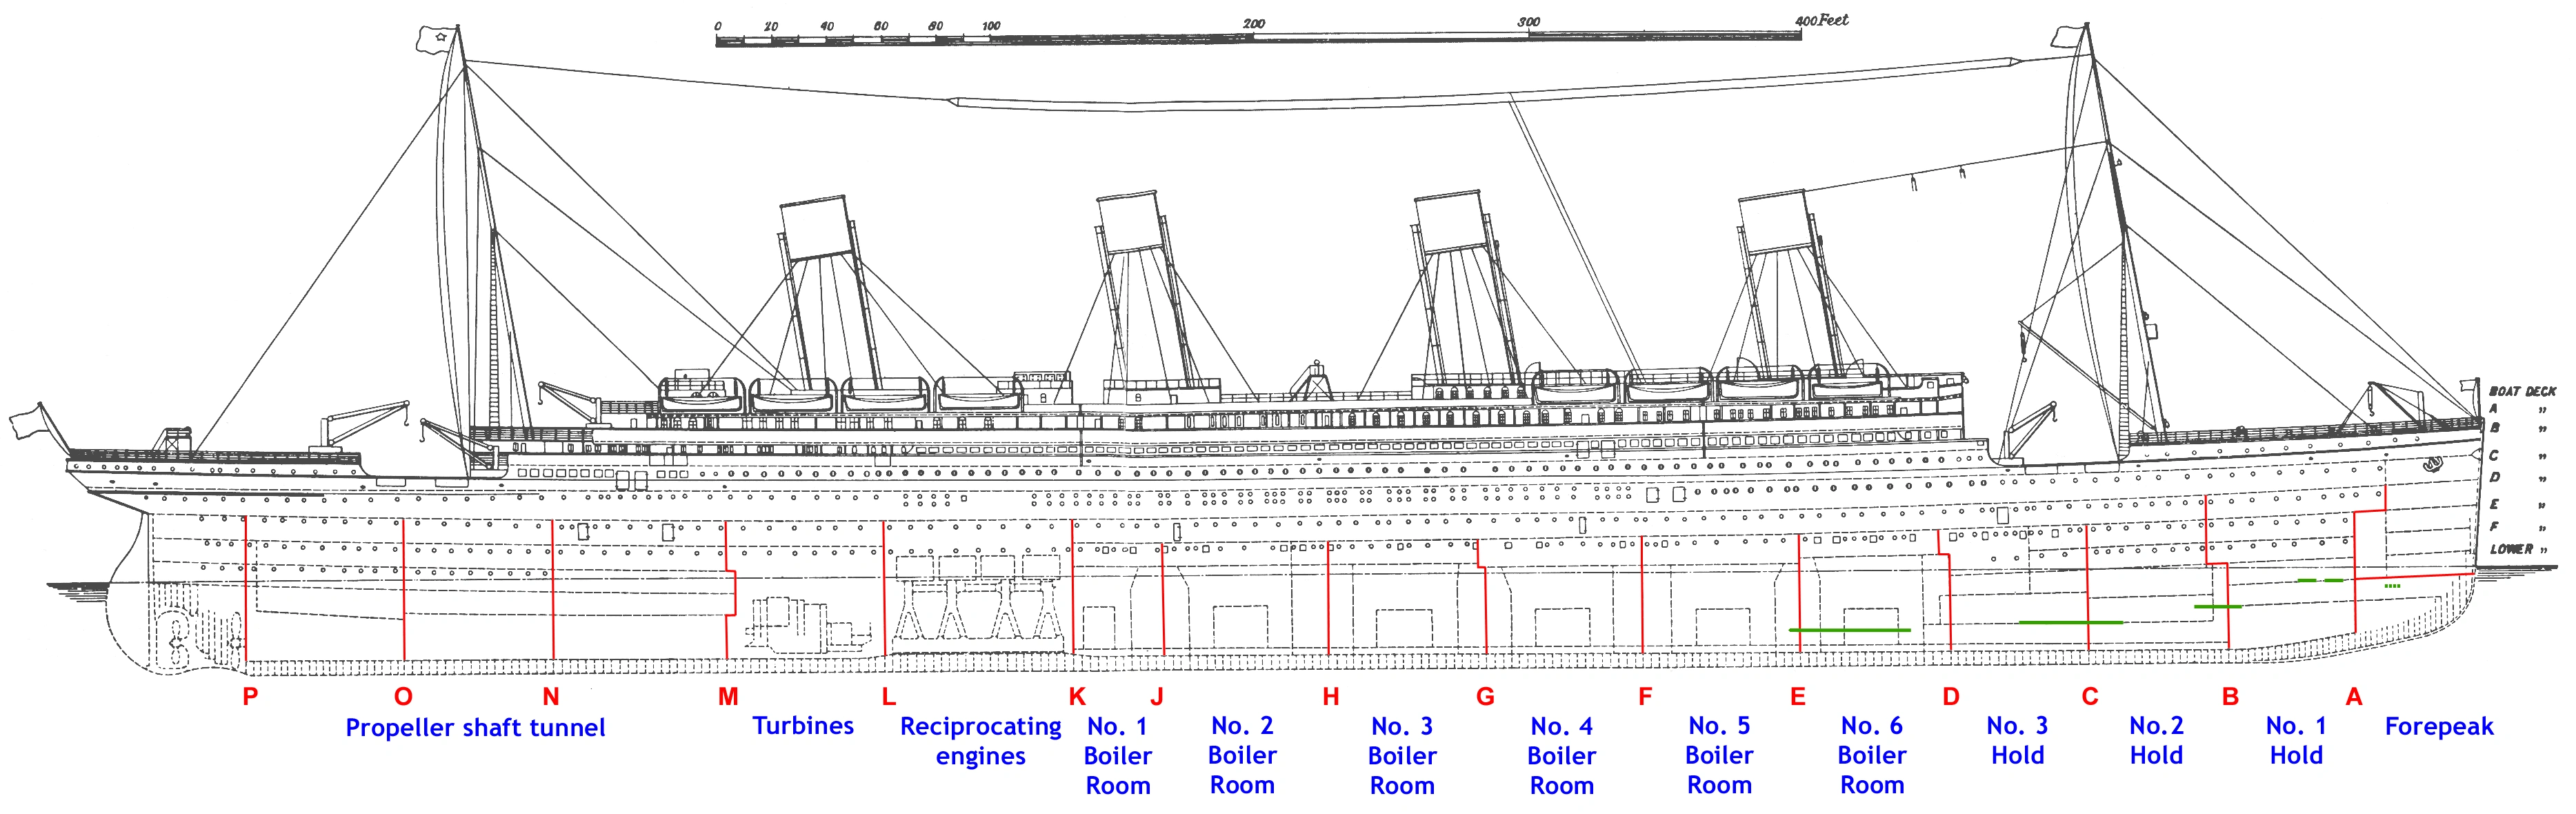

- On the Boat Deck there were 6 rooms labeled as T, U, W, X, Y, Z but only the T cabin is present in the dataset
- A, B and C decks were only for 1st class passengers
- D and E decks were for all classes
- F and G decks were for both 2nd and 3rd class passengers
- From going A to G, distance to the staircase increases which might be a factor of survival

Further information:
- T Deck: 6 cabins, accommodation for 7 people.
- A Deck: 36 cabins, accommodation for 48 people.
- B Deck: 101 numbered cabins, 2 of which are sitting rooms. Therefore it has 99 bedrooms with accomodation for 183 passengers.
- C Deck: Has 137 numbered cabins, 2 of which are sitting rooms. Therefore 135 cabins are able to accommodate 315 passengers.
- D Deck: Has a total of 49 cabins, being able to accommodate 119 passengers.
- E Deck: Has a total of 71 cabins, being able to accommodate 184 passengers.

Inference from above information and existing data:

- A Deck: 16 missing or empty cabins.
- B Deck: 50 missing or empty cabins.
- C Deck: 74 missing or empty cabins.
- D Deck: 15 missing or empty cabins.
- E Deck: 42 missing or empty cabins.

In [16]:
print(data.loc[data['Cabin'].isnull(), 'Pclass'].value_counts())

3    693
2    254
1     67
Name: Pclass, dtype: int64


We can choose to randomly assign upper-class passengers to Deck A, B, C or D, and second/third-class passengers to Deck D, E, F or G. However, I treat this information as additional information to variable `Pclass`, since these two variables somehow intersect with each other. Randomly assign values could be harmful to data accuracy. We can also  group Deck A,B,C and Deck D,E,F, that allows us to fill missing values with lower bias but the variable will be highly correlated with `Pclass`. Hence, I decide to insert a new value `M`(indicating missing) to missing values that are not connected with other Ticket. (Since passengers with same Ticket number are highly likely to share the same Cabin.

In [17]:
a = data.loc[data['Cabin'].isnull(), 'Ticket'].values
df_tmp = data.loc[(data['Cabin'].notnull()) & (data['Ticket'].isin(a)), ['Ticket', 'Cabin']]
for i in range(65,90):
    df_tmp.loc[df_tmp['Cabin'].str.startswith(chr(i)), 'Cabin'] = chr(i)
df_tmp.drop_duplicates(inplace = True)
df_tmp.rename({'Cabin': 'Cabin_fill'}, axis=1, inplace=True)

In [18]:
data.loc[data['Cabin'].isnull(), 'Cabin'] = data.loc[data['Cabin'].isnull(), 
                                                     ['Ticket', 'Cabin']].join(df_tmp.set_index('Ticket'), 
                                                                               on='Ticket')['Cabin_fill']

In [19]:
data.loc[data['Cabin'].isnull(), 'Cabin'] = 'M'

#### 2.2.3 `Embarked`

Embarked is a categorical feature and there are only 2 missing values in whole data set. Both of those passengers are female, upper class and they have the same ticket number. This means that they know each other and embarked from the same port together.<br><br>
The embarkation point could not be inferred from further data exploration, but these missing data are confirmed with `S` with the help of search engine.

In [20]:
data.loc[data['Embarked'].isnull(), 'Embarked'] = 'S'

#### 2.2.4 `Fare`

There is only one missing value in fare, which can be filled based on other variables

e.g. `Pclass = 3`

In [21]:
data.loc[data['Fare'].isnull(), 'Fare'] = data.loc[data['Pclass'] == 3, 'Fare'].mean()

### 2.3 Encode categorical variables

In [22]:
data_normal = data.copy()
data_tree = data.copy()

#### 2.3.1  ` Name`

##### 2.3.1.1 Group the name by social status (Rejected)

- The prefix of name is indicative of a passenger's social status.
- As with EDA results and web search, those prefix can be categorized as:

    - Ordinary: 
        - Mr. 
        - Master.
        - Mrs.|Ms.
        - Miss.
        - Don. 
        - Dona.
        - Mlle. 
        - Mme.

    - Military: 
        - Col.
        - Major. 
        - Capt.
        - Sir. 

    - Noble:
        - Jonkheer.
        - Lady.
        - the Countess.

    - Religious:
        - Rev. 
        
    - Academic:
        - Dr.

In [23]:
#data_train.loc[data_train['Name'].str.contains('Mr. |Mrs. |Ms. |Miss. |Master. |Don. |Dona. |Mlle. |Mme. '), 'Name'] = 'Ordinary'
#data_train.loc[data_train['Name'].str.contains('Col. |Major. |Capt. |Sir. '), 'Name'] = 'Military'
#data_train.loc[data_train['Name'].str.contains('Jonkheer. |Lady. |the Countess. '), 'Name'] = 'Noble'
#data_train.loc[data_train['Name'].str.contains('Rev. '), 'Name'] = 'Religious'
#data_train.loc[data_train['Name'].str.contains('Dr. '), 'Name'] = 'Academic'

#data_test.loc[data_test['Name'].str.contains('Mr. |Mrs. |Ms. |Miss. |Master. |Don. |Dona. |Mlle. |Mme. '), 'Name'] = 'Ordinary'
#data_test.loc[data_test['Name'].str.contains('Col. |Major. |Capt. |Sir. '), 'Name'] = 'Military'
#data_test.loc[data_test['Name'].str.contains('Jonkheer. |Lady. |the Countess. '), 'Name'] = 'Noble'
#data_test.loc[data_test['Name'].str.contains('Rev. '), 'Name'] = 'Religious'
#data_test.loc[data_test['Name'].str.contains('Dr. '), 'Name'] = 'Academic'


In [24]:
#print(f'The survival rate is {round(335/870, 2)} out of 870 Ordinaries.')
#print(f'The survival rate is {round(3/6, 2)} out of 6 Militaries.')
#print(f'The survival rate is {round(1/2, 2)} out of 2 Nobles.')
#print(f'The survival rate is {round(0/6, 2)} out of 6 Religious.')
#print(f'The survival rate is {round(3/7, 2)} out of 7 Doctors.')

It may make sense to group names as rigor as this. However, the corresponding survival rate is not informative in any way.(except `Religious`) Putting this into our models will create noise and decrease prediction accuracy. Since `Name` is somehow correlated with `Sex`, if we cannot make it an additional feature to `Sex`, we make it a better substitute for `Sex.

##### Group the name as a detailed `Sex` (Accepted)

In machine learning, we don't care about passengers' social status. As long as their identity doesn't make their survival rate different from gender (with statistical significance), we classify them as ordinary.

In [25]:
data_normal.loc[(~data_normal['Name'].str.contains('Master. |Rev. ')) & (data_normal['Sex'] == 'male'), 'Name'] = 'ordinary male'
data_normal.loc[(~data_normal['Name'].str.contains('Master. |Rev. ')) & (data_normal['Sex'] == 'female'), 'Name'] = 'ordinary female'
data_normal.loc[data_normal['Name'].str.contains('Master. '), 'Name'] = 'master'
data_normal.loc[data_normal['Name'].str.contains('Rev. '), 'Name'] = 'religious'

data_tree.loc[(~data_tree['Name'].str.contains('Master. |Rev. ')) & (data_tree['Sex'] == 'male'), 'Name'] = 'ordinary male'
data_tree.loc[(~data_tree['Name'].str.contains('Master. |Rev. ')) & (data_tree['Sex'] == 'female'), 'Name'] = 'ordinary female'
data_tree.loc[data_tree['Name'].str.contains('Master. '), 'Name'] = 'master'
data_tree.loc[data_tree['Name'].str.contains('Rev. '), 'Name'] = 'religious'


##### 2.3.1.2 Encode the grouped name with `one-hot` encoding and `ordinal` encoding<nr>
These titles are categorized without natural order or rank, and we cannot see any clear correlation difference between the survival rate and each variable below. Hence, one-hot encoding is more sensible. (ordinal encoding for tree based models)

In [26]:
print(data_normal.loc[data_normal['Survived'].notnull(), ['Survived', 'Name']].value_counts().sort_index())
print(f'The survival rate is {round(23/40, 2)} out of 40 masters.')
print(f'The survival rate is {round(233/314, 2)} out of 314 ordinary females.')
print(f'The survival rate is {round(86/531, 2)} out of 531 ordinary males.')
print(f'The survival rate is {round(0/6, 2)} out of 6 religious.')

Survived  Name           
0.0       master              17
          ordinary female     81
          ordinary male      445
          religious            6
1.0       master              23
          ordinary female    233
          ordinary male       86
dtype: int64
The survival rate is 0.57 out of 40 masters.
The survival rate is 0.74 out of 314 ordinary females.
The survival rate is 0.16 out of 531 ordinary males.
The survival rate is 0.0 out of 6 religious.


In [27]:
ohe = OneHotEncoder(sparse_output=False, dtype=int)

name_encode = pd.DataFrame(ohe.fit_transform(data_normal[['Name']]), columns=list(ohe.categories_[0]))
data_normal = data_normal.drop(['Name'], axis=1).join(name_encode)


oe = OrdinalEncoder(categories = [['religious', 'ordinary male', 'master', 'ordinary female']], dtype = int)
data_tree['Name'] = oe.fit_transform(data_tree[['Name']])

#### 2.3.2  `Sex`

##### Encode sex with `one-hot` encoding and `ordinal` encoding

Sex is classic **`nominal`** variable, which is generally encoded with one-hot encoding. (ordinal for tree based models)

In [28]:
sex_encode = pd.DataFrame(ohe.fit_transform(data_normal[['Sex']]), columns=list(ohe.categories_[0]))
data_normal = data_normal.drop(['Sex'], axis=1).join(sex_encode)


oe = OrdinalEncoder(categories = [['female', 'male']], dtype = int)
data_tree['Sex'] = oe.fit_transform(data_tree[['Sex']])

#### 2.3.3  `SibSp` & `Parch`

##### 2.3.3.1 Combine and recategorize the two variables 

SibSp and Parch are both objectively and intuitively very similar variables and they should give similar information to the survival rate. <br><br> 
From EDA, we can see highly correlated relationship between survival rate of each variable for figures 0, 1 and 2, which also take up most percentage of data. For figures greater than 2, their survival rate and weight is insignificant. Besides, as below, most of passengers who had no SibSp also had 0 Parch. This pattern is increasingly false as figure goes up.<br><br> 
Hence, we combine the two columns as `Family` and classify it based on the combined distribution. 

In [29]:
print(data_train['SibSp'].value_counts().sort_index())
print(data_train.loc[data_train['SibSp'] == data_train['Parch'], 'SibSp'].value_counts())    

print(data_train['Parch'].value_counts().sort_index())
print(data_train.loc[data_train['SibSp'] == data_train['Parch'], 'Parch'].value_counts()) 

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64
0    537
1     57
2      4
Name: SibSp, dtype: int64
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64
0    537
1     57
2      4
Name: Parch, dtype: int64


In [30]:
col_family = pd.DataFrame(data['SibSp'] + data['Parch'], columns=['Family'])

data[['Survived']].join(col_family).loc[data['Survived'].notnull()].value_counts().sort_index()

Survived  Family
0.0       0         374
          1          72
          2          43
          3           8
          4          12
          5          19
          6           8
          7           6
          10          7
1.0       0         163
          1          89
          2          59
          3          21
          4           3
          5           3
          6           4
dtype: int64

For variable `Family`:
- **0 : 60.27% ---- 0.30**
- **1 : 18.07% ---- 0.55**
- **2 : 11.45% ---- 0.58**
- **3 : 3.25% ---- 0.72**
- **4 : 1.68% ---- 0.2**
- **5 : 2.47% ---- 0.14**
- **6 : 1.34% ---- 0.33**
- **7 : 0.67% ---- 0.00**
- **10 : 0.79% ---- 0.00**
<br><br>
From above, it's reasonable to classify family size as `Alone`(0), `Small`(1,2,3), `Median`(4,5,6) and `Large`(10).

In [31]:
data_normal = data_normal.drop(['SibSp', 'Parch'], axis = 1).join(col_family)

data_tree = data_tree.drop(['SibSp', 'Parch'], axis = 1).join(col_family)

In [32]:
small, median, large = [1,2,3], [4,5,6], [7,8,9,10,11,12]

data_normal.loc[data_normal['Family'] == 0, 'Family'] = 'Alone'
data_normal.loc[data_normal['Family'].isin(small), 'Family'] = 'Small'
data_normal.loc[data_normal['Family'].isin(median), 'Family'] = 'Median'
data_normal.loc[data_normal['Family'].isin(large), 'Family'] = 'Large'

data_tree.loc[data_tree['Family'] == 0, 'Family'] = 'Alone'
data_tree.loc[data_tree['Family'].isin(small), 'Family'] = 'Small'
data_tree.loc[data_tree['Family'].isin(median), 'Family'] = 'Median'
data_tree.loc[data_tree['Family'].isin(large), 'Family'] = 'Large'

##### 2.3.3.2 Encode `family` with `ordinal` encoding 

Each category of family has clear ranking difference, which should be classified as **`ordinal`** variable. Hence, ordinal encoding is applied.

In [33]:
oe = OrdinalEncoder(categories = [['Alone', 'Small', 'Median', 'Large']], dtype = int)

data_normal['Family'] = oe.fit_transform(data_normal[['Family']])

data_tree['Family'] = oe.fit_transform(data_tree[['Family']])

#### 2.3.4  `Ticket`

##### Encode ticket with `count` encoding (Rejected)

There is no clear pattern found in this variable. However, some ticket number appears more than once, indicating the information of shared trip of some passengers. Thus, encoding ticket with count encoding could capture this information.

However, this encoding is refused after we discover a high correlation between this encoding and `Family`. (Family members are highly likely to share a same ticket)

In [31]:
#ticket_encode = pd.DataFrame(data['Ticket'].value_counts().index, columns=['Ticket']).join(
    #pd.DataFrame(data['Ticket'].value_counts().values, columns=['Ticket count']))

#data_normal = data_normal.merge(ticket_encode, how='left', on='Ticket').drop(['Ticket'], axis=1)

#data_tree = data_tree.merge(ticket_encode, how='left', on='Ticket').drop(['Ticket'], axis=1)

##### Replace ticket with a newly-created variable `Connected_Survival` (Accepted)

In [34]:
data_normal['Connected Survival'] = 0.5
data_tree['Connected Survival'] = 0.5

In [35]:
for tic, df_tic in data_normal.groupby('Ticket'):
    if len(df_tic) > 1:
        for ind, row in df_tic.iterrows():
            smax = df_tic.drop(ind)['Survived'].max()
            smin = df_tic.drop(ind)['Survived'].min()
            if smax == 1.0:
                data_normal.iloc[ind, data_normal.columns.get_loc('Connected Survival')] = 1
            elif smin == 0.0:
                data_normal.iloc[ind, data_normal.columns.get_loc('Connected Survival')] = 0
                
for tic, df_tic in data_tree.groupby('Ticket'):
    if len(df_tic) > 1:
        for ind, row in df_tic.iterrows():
            smax = df_tic.drop(ind)['Survived'].max()
            smin = df_tic.drop(ind)['Survived'].min()
            if smax == 1.0:
                data_tree.iloc[ind, data_tree.columns.get_loc('Connected Survival')] = 1
            elif smin == 0.0:
                data_tree.iloc[ind, data_tree.columns.get_loc('Connected Survival')] = 0

#### 2.3.5  `Cabin`

##### 2.3.5.1 Change cabin number to only deck letter 

In [36]:
for i in range(65,90):
    data_normal.loc[data_normal['Cabin'].str.startswith(chr(i)), 'Cabin'] = chr(i)
    data_tree.loc[data_tree['Cabin'].str.startswith(chr(i)), 'Cabin'] = chr(i)

##### 2.3.5.2 Encode cabin with `one-hot` encoding and `ordinal` encoding

In [37]:
cabin_encode = pd.DataFrame(ohe.fit_transform(data_normal[['Cabin']]), columns=list(ohe.categories_[0]))
data_normal = data_normal.drop(['Cabin'], axis=1).join(cabin_encode)

oe = OrdinalEncoder(categories = [['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'M']], dtype = int)
data_tree['Cabin'] = oe.fit_transform(data_tree[['Cabin']])

#### 2.3.6  `Embarked`

##### Encode embarkation point with `one-hot` encoding and `ordinal` encoding

In [38]:
data_normal.loc[data_normal['Embarked'] == 'C', 'Embarked'] = 'Cherbourg'
data_normal.loc[data_normal['Embarked'] == 'Q', 'Embarked'] = 'Queenstown'
data_normal.loc[data_normal['Embarked'] == 'S', 'Embarked'] = 'Southampton'


embark_encode = pd.DataFrame(ohe.fit_transform(data_normal[['Embarked']]), columns=list(ohe.categories_[0]))
data_normal = data_normal.drop(['Embarked'], axis=1).join(embark_encode)

oe = OrdinalEncoder(categories = [['C', 'Q', 'S']], dtype = int)
data_tree['Embarked'] = oe.fit_transform(data_tree[['Embarked']])

### 2.4 Scale quantitative variables 

#### 2.4.1 Remove outliers 
(not necessary because test dataset has that outlier too)

In [37]:
#data_normal = data_normal.loc[(data_normal['Survived'].notnull())&(data_normal['Fare'] != data_normal['Fare'].max())]
#data_tree = data_tree.loc[(data_tree['Survived'].notnull())&(data_tree['Fare'] != data_tree['Fare'].max())]

#### 2.4.2 MinMaxScaling and log-transform for `Age` and `Fare`

In [39]:
scaler = MinMaxScaler()

data_normal[['Age']] = scaler.fit_transform(data_normal[['Age']])
data_normal['Fare'] = data_normal['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

data_tree[['Age']] = scaler.fit_transform(data_tree[['Age']])
data_tree['Fare'] = data_tree['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

## 3. Prediction

### 3.1.1 Train & test split 

As from EDA, the data is imbalanced and the size of dataset is moderate. Hence, we split the data by **`Stratified K-fold cross validation`**.

In [40]:
data_tree.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Ticket', 'Fare', 'Cabin',
       'Embarked', 'Family', 'Connected Survival'],
      dtype='object')

In [41]:
data_tree_train = data_tree.iloc[0:891]
data_tree_test = data_tree.iloc[891:]

In [42]:
selected_features = ['Pclass', 'Name', 'Age', 'Fare', 'Cabin', 'Family', 'Connected Survival']
X, y = data_tree_train[selected_features], data_tree_train['Survived']

In [43]:
K, random_seed = 10, 2

skf = StratifiedKFold(n_splits = K, shuffle = True, random_state = random_seed)

### 3.1.2 Baseline model

In [44]:
bsl = RandomForestClassifier(oob_score = True)

In [45]:
bsl.fit(data_tree_train[['Sex', 'Pclass']], data_tree_train['Survived'])

RandomForestClassifier(oob_score=True)

In [46]:
print('baseline features are Sex and Pclass')
print(f'oob score of baseline model is {bsl.oob_score_}')

baseline features are Sex and Pclass
oob score of baseline model is 0.7643097643097643


**Feature Selection**

In [47]:
fs = RandomForestClassifier(min_samples_leaf = 20)

In [48]:
fs.fit(X,y)

RandomForestClassifier(min_samples_leaf=20)

In [49]:
fs.feature_importances_

array([0.09424065, 0.43962758, 0.05834255, 0.14563914, 0.05281277,
       0.04461467, 0.16472262])

In [50]:
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    fs.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], fs.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy: {accuracy_score(y.iloc[validation_index], fs.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.8564294631710362
  Validation accuracy: 0.8222222222222222
Fold 2:
  Training accuracy: 0.8466334164588528
  Validation accuracy: 0.8314606741573034
Fold 3:
  Training accuracy: 0.8591022443890274
  Validation accuracy: 0.7865168539325843
Fold 4:
  Training accuracy: 0.8528678304239401
  Validation accuracy: 0.8426966292134831
Fold 5:
  Training accuracy: 0.8553615960099751
  Validation accuracy: 0.8202247191011236
Fold 6:
  Training accuracy: 0.8478802992518704
  Validation accuracy: 0.8426966292134831
Fold 7:
  Training accuracy: 0.8491271820448878
  Validation accuracy: 0.8539325842696629
Fold 8:
  Training accuracy: 0.8478802992518704
  Validation accuracy: 0.8202247191011236
Fold 9:
  Training accuracy: 0.8541147132169576
  Validation accuracy: 0.8876404494382022
Fold 10:
  Training accuracy: 0.85785536159601
  Validation accuracy: 0.7865168539325843


### 3.2.1 Logistic Regression

The cost function of Logistic Regression is a convex function, which means the training fit is always optimized.

#### 3.2.1.1 Fit without regularization term

Since Logistic Regression is always optimized, this step is to check whether optimized model overfits the data. 

In [119]:
lr = LogisticRegression(max_iter = 1000)

In [120]:
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    lr.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], lr.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], lr.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.8389513108614233
  Validation accuracy:  0.8222222222222222
Fold 2:
  Training accuracy: 0.8379052369077307
  Validation accuracy:  0.8202247191011236
Fold 3:
  Training accuracy: 0.8416458852867831
  Validation accuracy:  0.8202247191011236
Fold 4:
  Training accuracy: 0.844139650872818
  Validation accuracy:  0.797752808988764
Fold 5:
  Training accuracy: 0.8428927680798005
  Validation accuracy:  0.8539325842696629
Fold 6:
  Training accuracy: 0.8403990024937655
  Validation accuracy:  0.8539325842696629
Fold 7:
  Training accuracy: 0.8391521197007481
  Validation accuracy:  0.8539325842696629
Fold 8:
  Training accuracy: 0.844139650872818
  Validation accuracy:  0.8202247191011236
Fold 9:
  Training accuracy: 0.8366583541147132
  Validation accuracy:  0.898876404494382
Fold 10:
  Training accuracy: 0.8453865336658354
  Validation accuracy:  0.8202247191011236


#### 3.2.1.2 Find the best `penalty` to fit using GridSearchCV

In [121]:
lr_grid = GridSearchCV(estimator = LogisticRegression(penalty = 'l2', solver = 'newton-cholesky', max_iter = 1000),
                  param_grid = {'C': [i/1000 for i in range(1,1000)]},
                  scoring = None,
                  refit = True,
                  cv = 10,
                  verbose = 0,
                  return_train_score = True)

In [122]:
lr_grid.fit(X,y)

print(lr_grid.best_estimator_)
print(lr_grid.best_score_)
print(lr_grid.best_params_)

LogisticRegression(C=0.487, max_iter=1000, solver='newton-cholesky')
0.8428838951310862
{'C': 0.487}


In [51]:
lr = lr_grid.best_estimator_
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    lr.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], lr.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], lr.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.8414481897627965
  Validation accuracy:  0.8222222222222222
Fold 2:
  Training accuracy: 0.8391521197007481
  Validation accuracy:  0.8426966292134831
Fold 3:
  Training accuracy: 0.844139650872818
  Validation accuracy:  0.8202247191011236
Fold 4:
  Training accuracy: 0.8466334164588528
  Validation accuracy:  0.8089887640449438
Fold 5:
  Training accuracy: 0.8428927680798005
  Validation accuracy:  0.8539325842696629
Fold 6:
  Training accuracy: 0.8416458852867831
  Validation accuracy:  0.8539325842696629
Fold 7:
  Training accuracy: 0.8416458852867831
  Validation accuracy:  0.8539325842696629
Fold 8:
  Training accuracy: 0.8453865336658354
  Validation accuracy:  0.8202247191011236
Fold 9:
  Training accuracy: 0.8403990024937655
  Validation accuracy:  0.898876404494382
Fold 10:
  Training accuracy: 0.8428927680798005
  Validation accuracy:  0.8202247191011236


### 3.2.2 Decision Tree

Decision Tree Classifier tends to overfit the data if we don't restrict the parameters. Hence we should directly adjust the parameters to optimize the cross validation accuracy.

#### 3.2.2.1 Compute model performance for each tuning parameter

**`max_depth`**

In [124]:
max_depth = [i for i in range(1,25)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in tqdm(range(24), total = 24, desc = 'Processing'):
    dt = DecisionTreeClassifier(max_depth = d+1)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        dt.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], dt.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], dt.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Processing:   0%|          | 0/24 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Decision Tree Cross Validation Accuracy')

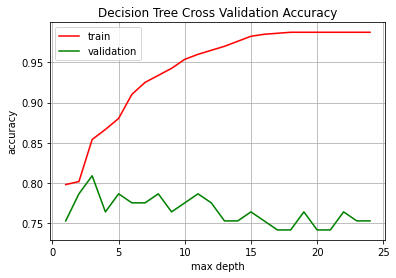

In [125]:
fig, ax = plt.subplots()
ax.plot(max_depth, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(max_depth, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(max_depth, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(max_depth, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Decision Tree Cross Validation Accuracy')

**`min_samples_split`**

In [44]:
min_samples_split = [i for i in range(2,51)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in tqdm(range(49), total = 49, desc = 'Processing'):
    dt = DecisionTreeClassifier(min_samples_split = d+2)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        dt.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], dt.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], dt.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Processing:   0%|          | 0/49 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Decision Tree Cross Validation Accuracy')

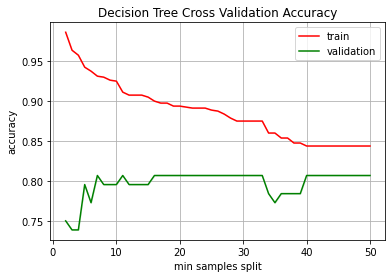

In [45]:
fig, ax = plt.subplots()
ax.plot(min_samples_split, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(min_samples_split, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(min_samples_split, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(min_samples_split, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('min samples split')
plt.ylabel('accuracy')
plt.title('Decision Tree Cross Validation Accuracy')

**`min_samples_leaf`**

In [46]:
min_samples_leaf = [i for i in range(1,101)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in tqdm(range(100), total = 100, desc = 'Processing'):
    dt = DecisionTreeClassifier(min_samples_leaf = d+1)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        dt.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], dt.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], dt.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Decision Tree Cross Validation Accuracy')

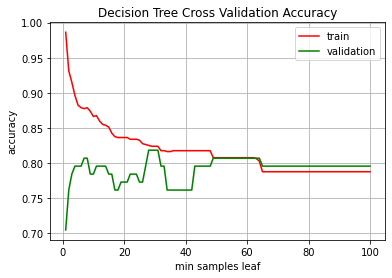

In [47]:
fig, ax = plt.subplots()
ax.plot(min_samples_leaf, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(min_samples_leaf, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(min_samples_leaf, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(min_samples_leaf, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('min samples leaf')
plt.ylabel('accuracy')
plt.title('Decision Tree Cross Validation Accuracy')

#### 3.2.2.2 Optimize the parameters

**`GridSearchCV`**

In [44]:
dt_grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                  param_grid = {'criterion': ('gini', 'entropy'),
                                'max_depth': [i for i in range(3,7)],
                                'min_samples_split': [i for i in range(2,10)],
                                'min_samples_leaf': [i for i in range(1,40)]},
                  scoring = None,
                  refit = True,
                  cv = 10,
                  verbose = 0,
                  return_train_score = True)

In [45]:
dt_grid.fit(X,y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             return_train_score=True)

In [46]:
print(dt_grid.best_score_)
print(dt_grid.best_params_)

0.8345377936670072
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [47]:
dt = dt_grid.best_estimator_
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    dt.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], dt.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], dt.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.8423028785982478
  Validation accuracy:  0.8539325842696629
Fold 2:
  Training accuracy: 0.851063829787234
  Validation accuracy:  0.8202247191011236
Fold 3:
  Training accuracy: 0.8435544430538173
  Validation accuracy:  0.7865168539325843
Fold 4:
  Training accuracy: 0.8448060075093867
  Validation accuracy:  0.8202247191011236
Fold 5:
  Training accuracy: 0.8523153942428036
  Validation accuracy:  0.8314606741573034
Fold 6:
  Training accuracy: 0.8473091364205256
  Validation accuracy:  0.8202247191011236
Fold 7:
  Training accuracy: 0.8473091364205256
  Validation accuracy:  0.8089887640449438
Fold 8:
  Training accuracy: 0.8423028785982478
  Validation accuracy:  0.8202247191011236
Fold 9:
  Training accuracy: 0.8475
  Validation accuracy:  0.8181818181818182
Fold 10:
  Training accuracy: 0.84875
  Validation accuracy:  0.8068181818181818


### 3.2.3 Support Vector Machine

In [195]:
sv = SVC()

In [196]:
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    sv.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], sv.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], sv.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.8339575530586767
  Validation accuracy:  0.8333333333333334
Fold 2:
  Training accuracy: 0.8291770573566085
  Validation accuracy:  0.8764044943820225
Fold 3:
  Training accuracy: 0.8354114713216958
  Validation accuracy:  0.8202247191011236
Fold 4:
  Training accuracy: 0.8391521197007481
  Validation accuracy:  0.7865168539325843
Fold 5:
  Training accuracy: 0.830423940149626
  Validation accuracy:  0.8651685393258427
Fold 6:
  Training accuracy: 0.8354114713216958
  Validation accuracy:  0.8202247191011236
Fold 7:
  Training accuracy: 0.8316708229426434
  Validation accuracy:  0.8539325842696629
Fold 8:
  Training accuracy: 0.8354114713216958
  Validation accuracy:  0.8202247191011236
Fold 9:
  Training accuracy: 0.830423940149626
  Validation accuracy:  0.8651685393258427
Fold 10:
  Training accuracy: 0.8379052369077307
  Validation accuracy:  0.797752808988764


In [52]:
sv_grid = GridSearchCV(estimator = SVC(probability=True),
                  param_grid = {'kernel': ['rbf'], 
                                'gamma': [0.001, 0.01, 0.1, 1],
                                'C': [1, 10, 50, 100, 200, 300, 1000]},
                  scoring = None,
                  refit = True,
                  cv = 10,
                  verbose = 1,
                  return_train_score = False)

In [53]:
sv_grid.fit(X,y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10, estimator=SVC(probability=True),
             param_grid={'C': [1, 10, 50, 100, 200, 300, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
             verbose=1)

In [54]:
print(sv_grid.best_score_)
print(sv_grid.best_params_)

0.8518227215980024
{'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}


In [55]:
sv = sv_grid.best_estimator_
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    sv.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], sv.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], sv.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.8714107365792759
  Validation accuracy:  0.8222222222222222
Fold 2:
  Training accuracy: 0.871571072319202
  Validation accuracy:  0.8539325842696629
Fold 3:
  Training accuracy: 0.8815461346633416
  Validation accuracy:  0.7415730337078652
Fold 4:
  Training accuracy: 0.8740648379052369
  Validation accuracy:  0.797752808988764
Fold 5:
  Training accuracy: 0.8740648379052369
  Validation accuracy:  0.8651685393258427
Fold 6:
  Training accuracy: 0.8753117206982544
  Validation accuracy:  0.8876404494382022
Fold 7:
  Training accuracy: 0.8703241895261845
  Validation accuracy:  0.8651685393258427
Fold 8:
  Training accuracy: 0.8703241895261845
  Validation accuracy:  0.8764044943820225
Fold 9:
  Training accuracy: 0.8640897755610972
  Validation accuracy:  0.9101123595505618
Fold 10:
  Training accuracy: 0.8790523690773068
  Validation accuracy:  0.8089887640449438


### 3.2.4 Random Forest

#### 3.2.4.1 Compute model performance for each tuning parameter

**`n_estimators`**

In [135]:
n_estimators = [i for i in range(1,301)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in tqdm(range(300), total = 300, desc = 'Processing'):
    rf = RandomForestClassifier(n_estimators = d+1, min_samples_leaf = 20)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        rf.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], rf.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], rf.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Processing:   0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Random Forest Cross Validation Accuracy')

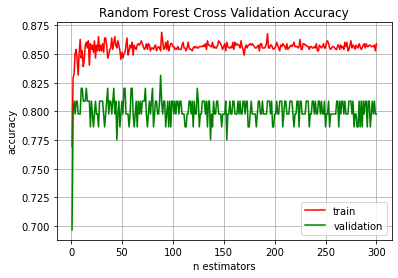

In [136]:
fig, ax = plt.subplots()
ax.plot(n_estimators, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(n_estimators, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(n_estimators, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(n_estimators, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('n estimators')
plt.ylabel('accuracy')
plt.title('Random Forest Cross Validation Accuracy')

**`max_depth`**

In [128]:
max_depth = [i for i in range(1,7)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in range(6):
    rf = RandomForestClassifier(max_depth = d+1, n_estimators = 200)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        rf.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], rf.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], rf.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Text(0.5, 1.0, 'Random Forest Cross Validation Accuracy')

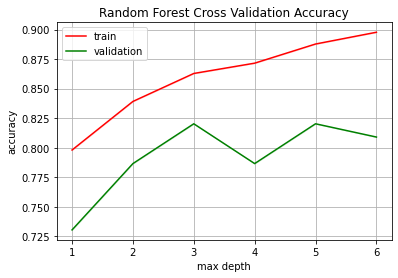

In [129]:
fig, ax = plt.subplots()
ax.plot(max_depth, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(max_depth, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(max_depth, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(max_depth, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Random Forest Cross Validation Accuracy')

**`min_samples_split`**

In [131]:
min_samples_split = [i for i in range(2,51)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in tqdm(range(49), total = 49, desc = 'Processing'):
    rf = RandomForestClassifier(min_samples_split = d+2)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        rf.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], rf.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], rf.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Processing:   0%|          | 0/49 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Random Forest Cross Validation Accuracy')

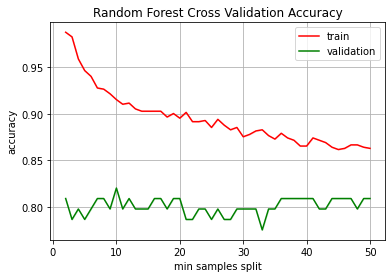

In [132]:
fig, ax = plt.subplots()
ax.plot(min_samples_split, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(min_samples_split, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(min_samples_split, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(min_samples_split, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('min samples split')
plt.ylabel('accuracy')
plt.title('Random Forest Cross Validation Accuracy')

**`min_samples_leaf`**

In [133]:
min_samples_leaf = [i for i in range(1,51)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in tqdm(range(50), total = 50, desc = 'Processing'):
    rf = RandomForestClassifier(min_samples_leaf = d+1, n_estimators = 100)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        rf.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], rf.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], rf.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Random Forest Cross Validation Accuracy')

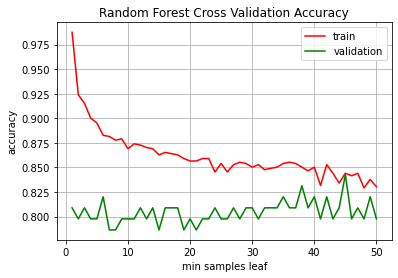

In [134]:
fig, ax = plt.subplots()
ax.plot(min_samples_leaf, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(min_samples_leaf, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(min_samples_leaf, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(min_samples_leaf, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('min samples leaf')
plt.ylabel('accuracy')
plt.title('Random Forest Cross Validation Accuracy')

#### 3.2.4.2 Optimize the parameters

**`RandomizedSearchCV`**

In [79]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),
                  param_distributions = {'n_estimators': [i for i in range(100,300)],
                                'criterion': ('gini', 'entropy'),
                                'min_samples_split': [20]},
                  n_iter = 100,
                  scoring = None,
                  refit = True,
                  cv = 5,
                  verbose = 1,
                  return_train_score = False)

In [80]:
rf_random.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'criterion': ('gini', 'entropy'),
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'min_samples_leaf': [10, 11, 12, 13, 14,
                                                             15, 16, 17, 18,
                                                             19],
                                        'min_samples_split': [3, 4, 5, 6, 7, 8,
                                                              9, 10, 11, 12, 13,
                                                              14, 15, 16, 17,
                                                              18, 19],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                                                         74, 75, 76, 77, 78, 79, ...]},
                   verbose=1)

In [81]:
print(rf_random.best_score_)
print(rf_random.best_params_)

0.8186758077826445
{'n_estimators': 53, 'min_samples_split': 3, 'min_samples_leaf': 13, 'max_depth': 5, 'criterion': 'gini'}


In [48]:
#rf = rf_random.best_estimator_
rf = RandomForestClassifier(min_samples_leaf = 20)
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    rf.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], rf.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], rf.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.8097622027534418
  Validation accuracy:  0.797752808988764
Fold 2:
  Training accuracy: 0.8160200250312891
  Validation accuracy:  0.8089887640449438
Fold 3:
  Training accuracy: 0.8172715894868585
  Validation accuracy:  0.7752808988764045
Fold 4:
  Training accuracy: 0.8085106382978723
  Validation accuracy:  0.8089887640449438
Fold 5:
  Training accuracy: 0.804755944931164
  Validation accuracy:  0.8426966292134831
Fold 6:
  Training accuracy: 0.8310387984981227
  Validation accuracy:  0.8202247191011236
Fold 7:
  Training accuracy: 0.8222778473091364
  Validation accuracy:  0.8202247191011236
Fold 8:
  Training accuracy: 0.8110137672090113
  Validation accuracy:  0.8202247191011236
Fold 9:
  Training accuracy: 0.81875
  Validation accuracy:  0.8181818181818182
Fold 10:
  Training accuracy: 0.80875
  Validation accuracy:  0.8068181818181818


**`GridSearchCV`**

In [139]:
rf_grid = GridSearchCV(estimator = RandomForestClassifier(),
                  param_grid = {'n_estimators': [i for i in range(50,100)],
                                'criterion': ('gini', 'entropy'),
                                'min_samples_split': [i for i in range(10, 30)]},
                  scoring = None,
                  refit = True,
                  cv = 10,
                  verbose = 1,
                  return_train_score = False)

In [140]:
rf_grid.fit(X,y)

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'min_samples_split': [10, 11, 12, 13, 14, 15, 16, 17,
                                               18, 19, 20, 21, 22, 23, 24, 25,
                                               26, 27, 28, 29],
                         'n_estimators': [50, 51, 52, 53, 54, 55, 56, 57, 58,
                                          59, 60, 61, 62, 63, 64, 65, 66, 67,
                                          68, 69, 70, 71, 72, 73, 74, 75, 76,
                                          77, 78, 79, ...]},
             verbose=1)

In [141]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.86645443196005
{'criterion': 'entropy', 'min_samples_split': 14, 'n_estimators': 71}


In [56]:
rf = rf_grid.best_estimator_
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    rf.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], rf.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], rf.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.9026217228464419
  Validation accuracy:  0.8444444444444444
Fold 2:
  Training accuracy: 0.9002493765586035
  Validation accuracy:  0.8764044943820225
Fold 3:
  Training accuracy: 0.9064837905236908
  Validation accuracy:  0.797752808988764
Fold 4:
  Training accuracy: 0.8965087281795511
  Validation accuracy:  0.8876404494382022
Fold 5:
  Training accuracy: 0.9039900249376559
  Validation accuracy:  0.8202247191011236
Fold 6:
  Training accuracy: 0.9039900249376559
  Validation accuracy:  0.8876404494382022
Fold 7:
  Training accuracy: 0.9014962593516209
  Validation accuracy:  0.8764044943820225
Fold 8:
  Training accuracy: 0.9014962593516209
  Validation accuracy:  0.8651685393258427
Fold 9:
  Training accuracy: 0.8952618453865336
  Validation accuracy:  0.8876404494382022
Fold 10:
  Training accuracy: 0.9089775561097256
  Validation accuracy:  0.8089887640449438


### 3.2.5 AdaBoost

#### 3.2.5.1 Compute model performance for each tuning parameter

**`n_estimators`** versus **`learning_date`**

In [154]:
n_estimators = [i for i in range(20,200)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in tqdm(range(180), total = 180, desc = 'Processing'):
    ada = AdaBoostClassifier(n_estimators = d+20, learning_rate = 0.03)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        ada.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], ada.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], ada.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Processing:   0%|          | 0/180 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Adaptive Boosting Cross Validation Accuracy')

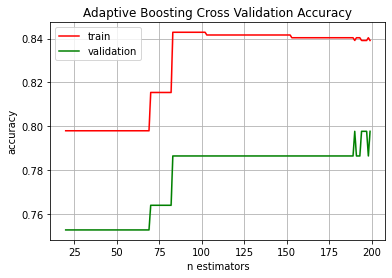

In [155]:
fig, ax = plt.subplots()
ax.plot(n_estimators, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(n_estimators, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(n_estimators, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(n_estimators, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('n estimators')
plt.ylabel('accuracy')
plt.title('Adaptive Boosting Cross Validation Accuracy')

#### 3.2.5.2 Optimize the parameters

**`GridSearchCV`**

In [157]:
ada_grid = GridSearchCV(estimator = AdaBoostClassifier(),
                  param_grid = {'algorithm': ['SAMME', 'SAMME.R'],
                                'n_estimators': [i for i in range(170,250)],
                                'learning_rate': [i/100 for i in range(5,15)]},
                  scoring = None,
                  refit = True,
                  cv = 10,
                  verbose = 1,
                  return_train_score = True)

In [158]:
ada_grid.fit(X,y)

Fitting 10 folds for each of 1600 candidates, totalling 16000 fits


GridSearchCV(cv=10, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
                                           0.11, 0.12, 0.13, 0.14],
                         'n_estimators': [170, 171, 172, 173, 174, 175, 176,
                                          177, 178, 179, 180, 181, 182, 183,
                                          184, 185, 186, 187, 188, 189, 190,
                                          191, 192, 193, 194, 195, 196, 197,
                                          198, 199, ...]},
             return_train_score=True, verbose=1)

In [159]:
print(ada_grid.best_score_)
print(ada_grid.best_params_)

0.8440324594257179
{'algorithm': 'SAMME.R', 'learning_rate': 0.07, 'n_estimators': 218}


In [57]:
ada = ada_grid.best_estimator_
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    ada.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], ada.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], ada.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.8551810237203495
  Validation accuracy:  0.8444444444444444
Fold 2:
  Training accuracy: 0.8503740648379052
  Validation accuracy:  0.8426966292134831
Fold 3:
  Training accuracy: 0.8491271820448878
  Validation accuracy:  0.8314606741573034
Fold 4:
  Training accuracy: 0.8528678304239401
  Validation accuracy:  0.8089887640449438
Fold 5:
  Training accuracy: 0.8516209476309227
  Validation accuracy:  0.8539325842696629
Fold 6:
  Training accuracy: 0.8466334164588528
  Validation accuracy:  0.797752808988764
Fold 7:
  Training accuracy: 0.8516209476309227
  Validation accuracy:  0.8539325842696629
Fold 8:
  Training accuracy: 0.8516209476309227
  Validation accuracy:  0.8314606741573034
Fold 9:
  Training accuracy: 0.8453865336658354
  Validation accuracy:  0.9101123595505618
Fold 10:
  Training accuracy: 0.8541147132169576
  Validation accuracy:  0.8202247191011236


### 3.2.6 Gradient Boosting

In [161]:
gbc_grid = GridSearchCV(estimator = GradientBoostingClassifier(),
                       param_grid = {'loss' : ["log_loss"],
                                     'n_estimators' : [100,200,300],
                                     'learning_rate': [0.1, 0.05, 0.01],
                                     'max_depth': [4, 8],
                                     'min_samples_leaf': [100,150],
                                     'max_features': [0.3, 0.1]},
                       scoring = None,
                       refit = True,
                       cv = 10,
                       verbose = 0,
                       return_train_score = True)

In [162]:
gbc_grid.fit(X,y)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'loss': ['log_loss'], 'max_depth': [4, 8],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True)

In [163]:
print(gbc_grid.best_score_)
print(gbc_grid.best_params_)

0.8529338327091137
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 8, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 300}


In [58]:
gbc = gbc_grid.best_estimator_
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    gbc.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], gbc.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], gbc.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.8876404494382022
  Validation accuracy:  0.8111111111111111
Fold 2:
  Training accuracy: 0.8778054862842892
  Validation accuracy:  0.8876404494382022
Fold 3:
  Training accuracy: 0.8865336658354115
  Validation accuracy:  0.797752808988764
Fold 4:
  Training accuracy: 0.8790523690773068
  Validation accuracy:  0.8314606741573034
Fold 5:
  Training accuracy: 0.8815461346633416
  Validation accuracy:  0.8876404494382022
Fold 6:
  Training accuracy: 0.8765586034912718
  Validation accuracy:  0.8764044943820225
Fold 7:
  Training accuracy: 0.8790523690773068
  Validation accuracy:  0.8651685393258427
Fold 8:
  Training accuracy: 0.8778054862842892
  Validation accuracy:  0.8764044943820225
Fold 9:
  Training accuracy: 0.8827930174563591
  Validation accuracy:  0.898876404494382
Fold 10:
  Training accuracy: 0.8915211970074813
  Validation accuracy:  0.797752808988764


### 3.2.7 XGBoost

XGBoost is prone to overfitting and highly flexible.

#### 3.2.7.1 Compute model performance for each tuning parameter

**`reg_lambda`**

In [165]:
reg_lambda = [i for i in range(1,301)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in tqdm(range(300), total = 300, desc = 'Processing'):
    xgb = XGBClassifier(reg_lambda = d+1, n_estimators = 100, learning_rate = 0.1, max_depth = 14)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        xgb.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], xgb.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], xgb.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Processing:   0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 1.0, 'XGBoost Cross Validation Accuracy')

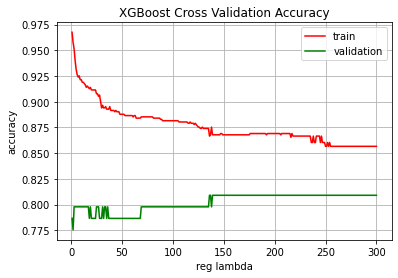

In [166]:
fig, ax = plt.subplots()
ax.plot(reg_lambda, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(reg_lambda, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(reg_lambda, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(reg_lambda, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('reg lambda')
plt.ylabel('accuracy')
plt.title('XGBoost Cross Validation Accuracy')

**`n_estimators`** versus **`learning_rate`**

In [171]:
n_estimators = [i for i in range(1,301)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in tqdm(range(300), total = 300, desc = 'Processing'):
    xgb = XGBClassifier(n_estimators = d+1, reg_lambda = 20, learning_rate = 0.05)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        xgb.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], xgb.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], xgb.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Processing:   0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 1.0, 'XGBoost Cross Validation Accuracy')

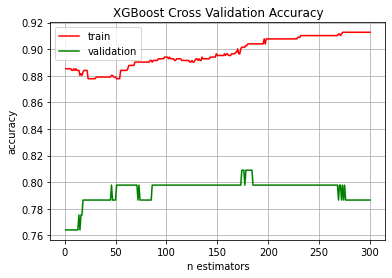

In [172]:
fig, ax = plt.subplots()
ax.plot(n_estimators, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(n_estimators, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(n_estimators, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(n_estimators, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('n estimators')
plt.ylabel('accuracy')
plt.title('XGBoost Cross Validation Accuracy')

**`max_depth`**

In [131]:
max_depth = [i for i in range(1,25)]
avg_train_accuracy = []
max_train_accuracy = []
min_train_accuracy = []
avg_validation_accuracy = []
max_validation_accuracy = []
min_validation_accuracy = []

for d in tqdm(range(24), total = 24, desc = 'Processing'):
    xgb = XGBClassifier(max_depth = d+1, reg_lambda = 10, learning_rate = 0.05, n_estimators = 300)
    
    for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
        train_accu = []
        validation_accu = []
        xgb.fit(X.iloc[training_index], y.iloc[training_index])
        train_accu.append(accuracy_score(y.iloc[training_index], xgb.predict(X.iloc[training_index])))
        validation_accu.append(accuracy_score(y.iloc[validation_index], xgb.predict(X.iloc[validation_index])))
    avg_train_accuracy.append(mean(train_accu))
    max_train_accuracy.append(max(train_accu))
    min_train_accuracy.append(min(train_accu))
    avg_validation_accuracy.append(mean(validation_accu))
    max_validation_accuracy.append(max(validation_accu))
    min_validation_accuracy.append(min(validation_accu))

Processing:   0%|          | 0/24 [00:00<?, ?it/s]

Text(0.5, 1.0, 'XGBoost Cross Validation Accuracy')

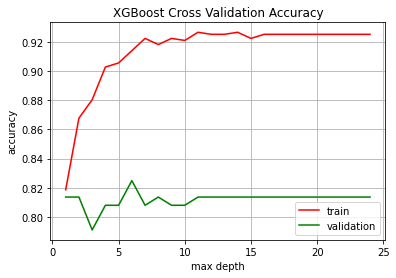

In [132]:
fig, ax = plt.subplots()
ax.plot(max_depth, avg_train_accuracy, label = 'train', color = 'r')
ax.plot(max_depth, avg_validation_accuracy, label = 'validation', color = 'g')
ax.fill_between(max_depth, min_train_accuracy, max_train_accuracy, color = 'r', alpha = 0.1)
ax.fill_between(max_depth, min_validation_accuracy, max_validation_accuracy, color = 'g', alpha = 0.1)
ax.grid()
ax.legend()
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('XGBoost Cross Validation Accuracy')

#### 3.2.7.2 Optimize the parameters

**`GridSearchCV`**

In [175]:
xgb_grid = GridSearchCV(estimator = XGBClassifier(),
                  param_grid = {'n_estimators': [100, 150, 170, 200],
                                'learning_rate': [0.05, 0.07, 0.1, 0.12, 0.15],
                                'max_depth': [i for i in range(3,8)],
                                'reg_lambda': [1, 5, 10, 20, 50],
                                'colsample_bytree': [i/10 for i in range(2,9)]},
                  scoring = None,
                  refit = True,
                  cv = 10,
                  verbose = 1,
                  return_train_score = False)

In [176]:
xgb_grid.fit(X,y)

Fitting 10 folds for each of 3500 candidates, totalling 35000 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                              0.8],
                         'learning_rate': [0.05, 0.07, 0.1, 0.12, 0.15],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 170, 200],
                         'reg_lambda': [1, 5, 10, 20, 50]},
             verbose=1)

In [177]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.8630961298377029
{'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 5}


In [59]:
xgb = xgb_grid.best_estimator_
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    xgb.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], xgb.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], xgb.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.9076154806491885
  Validation accuracy:  0.8444444444444444
Fold 2:
  Training accuracy: 0.9039900249376559
  Validation accuracy:  0.8651685393258427
Fold 3:
  Training accuracy: 0.9052369077306733
  Validation accuracy:  0.7640449438202247
Fold 4:
  Training accuracy: 0.9014962593516209
  Validation accuracy:  0.8651685393258427
Fold 5:
  Training accuracy: 0.9064837905236908
  Validation accuracy:  0.8651685393258427
Fold 6:
  Training accuracy: 0.9052369077306733
  Validation accuracy:  0.8651685393258427
Fold 7:
  Training accuracy: 0.899002493765586
  Validation accuracy:  0.8764044943820225
Fold 8:
  Training accuracy: 0.8965087281795511
  Validation accuracy:  0.8764044943820225
Fold 9:
  Training accuracy: 0.9052369077306733
  Validation accuracy:  0.898876404494382
Fold 10:
  Training accuracy: 0.9114713216957606
  Validation accuracy:  0.797752808988764


**`RandomizedSearchCV`**

In [85]:
xgb_random = RandomizedSearchCV(estimator = XGBClassifier(),
                  param_distributions = {'n_estimators': [i for i in range(150, 160)],
                                         'learning_rate': [i/100 for i in range(5, 20)],
                                         'max_depth': [i for i in range(1,8)],
                                         'reg_lambda': [i for i in range(1,10)],
                                         'colsample_bytree': [i/10 for i in range(2,9)]},
                  n_iter = 1000,
                  scoring = None,
                  refit = True,
                  cv = 5,
                  verbose = 1,
                  return_train_score = False)

In [86]:
xgb_random.fit(X,y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=1000,
                   param_distributions={'colsample_bytree': [0.2, 0.3, 0.4, 0.5,
                                                             0.6, 0.7, 0.8],
                                        'learning_rate': [0.05, 0.06, 0.07,
                                                          0.08, 0.09, 0.1, 0.11,
                                                          0.12, 0.13, 0.14,
                                                          0.15, 0.16, 0.17,
                                                          0.18, 0.19],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7],
                                        'n_estimators': [150, 151, 152, 153,
                                                         154, 155, 156, 157,
                                                         158, 159],
                                        'reg_lambda': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9]},
                   verbose=1)

In [87]:
print(xgb_random.best_score_)
print(xgb_random.best_params_)

0.8434837808671365
{'reg_lambda': 2, 'n_estimators': 151, 'max_depth': 6, 'learning_rate': 0.15, 'colsample_bytree': 0.3}


In [88]:
xgb = xgb_random.best_estimator_
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    xgb.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], xgb.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], xgb.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.9056338028169014
  Validation accuracy:  0.8202247191011236
Fold 2:
  Training accuracy: 0.8859154929577465
  Validation accuracy:  0.8202247191011236
Fold 3:
  Training accuracy: 0.8802816901408451
  Validation accuracy:  0.8595505617977528
Fold 4:
  Training accuracy: 0.9015471167369902
  Validation accuracy:  0.8361581920903954
Fold 5:
  Training accuracy: 0.8945147679324894
  Validation accuracy:  0.8135593220338984


### 3.2.8 Voting Classifier

#### 3.2.8.1

In [112]:
vc = VotingClassifier(estimators = [('AdaBoost', ada),
                                    ('Logistic Regression', lr)], 
                      voting = 'hard')

In [113]:
for i, (training_index, validation_index) in enumerate(skf.split(X,y)):
    vc.fit(X.iloc[training_index], y.iloc[training_index])
    print(f"Fold {i+1}:")
    print(f"  Training accuracy: {accuracy_score(y.iloc[training_index], vc.predict(X.iloc[training_index]))}")
    print(f"  Validation accuracy:  {accuracy_score(y.iloc[validation_index], vc.predict(X.iloc[validation_index]))}")

Fold 1:
  Training accuracy: 0.8489388264669163
  Validation accuracy:  0.8333333333333334
Fold 2:
  Training accuracy: 0.8453865336658354
  Validation accuracy:  0.8651685393258427
Fold 3:
  Training accuracy: 0.8478802992518704
  Validation accuracy:  0.8314606741573034
Fold 4:
  Training accuracy: 0.8528678304239401
  Validation accuracy:  0.8202247191011236
Fold 5:
  Training accuracy: 0.8503740648379052
  Validation accuracy:  0.8539325842696629
Fold 6:
  Training accuracy: 0.8453865336658354
  Validation accuracy:  0.8426966292134831
Fold 7:
  Training accuracy: 0.8466334164588528
  Validation accuracy:  0.8539325842696629
Fold 8:
  Training accuracy: 0.8503740648379052
  Validation accuracy:  0.8314606741573034
Fold 9:
  Training accuracy: 0.8453865336658354
  Validation accuracy:  0.898876404494382
Fold 10:
  Training accuracy: 0.8491271820448878
  Validation accuracy:  0.8202247191011236


## 4. Output test result

Choose the best model to predict test data and output the result.

In [114]:
vc.fit(X,y)

VotingClassifier(estimators=[('AdaBoost',
                              AdaBoostClassifier(learning_rate=0.07,
                                                 n_estimators=218)),
                             ('Logistic Regression',
                              LogisticRegression(C=0.487, max_iter=1000,
                                                 solver='newton-cholesky'))])

In [115]:
result = pd.concat([test_index, pd.DataFrame(vc.predict(data_tree_test[selected_features]), columns=['Survived'])], axis=1)
result['Survived'] = result['Survived'].astype('int')
result

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [116]:
result.to_csv('prediction.csv', index=False)

Kaggle top 1%: 0.815